### Conversion Rate

Source : http://datascientistjobinterview.com/

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.

We have data about users who hit the site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site). 

The project is to: 
<li>Predict conversion rate 
<li>Come up with recommendations for the product team and the marketing team to improve conversion rate 

### Data Description

The table is "conversion_data". It has information about signed-in users during one session. Each row is a user session.

##### Columns: 

<li>country : user country based on the IP address 
<li>age : user age. Self-reported at sign-in step 
<li>new_user : whether the user created the account during this session or had already an account and simply came back to the site 
<li>source : marketing channel source 
<ul><ul><li>Ads: came to the site by clicking on an advertisement 
<li>Seo: came to the site by clicking on search results 
<li>Direct: came to the site by directly typing the URL on the browser 
</ul></ul>
<li>total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session. 
<li>converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions. 

In [120]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, roc_curve,auc,accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [8]:
#Read Data
conversions_df=pd.read_csv("conversion_data.csv")

#### Summarize Data

In [9]:
conversions_df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [10]:
conversions_df.shape

(316200, 6)

In [11]:
conversions_df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [14]:
conversions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


#### Visualization

What is the conversion rate?

In [64]:
#Observation count by label
conversions_df.converted.value_counts()

0    306000
1     10200
Name: converted, dtype: int64

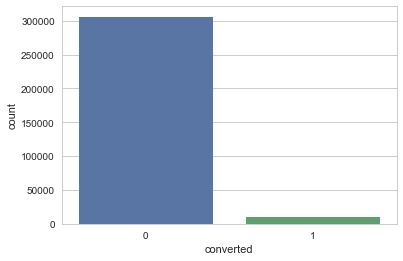

In [65]:
#Plot label category count
sns.countplot(conversions_df.converted)

In [28]:
#Conversion Rate
conversion_rate=(conversions_df[conversions_df.converted==1].size/conversions_df.converted.size)*100
print("Conversion Rate = ",conversion_rate, " %")

Conversion Rate =  19.3548387097  %


********************************************************************************************************************************

How is the sample geographically distributed?

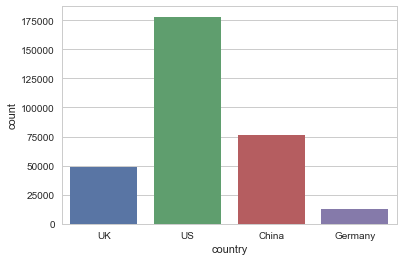

In [66]:
#Plot observation count by country
sns.countplot(conversions_df.country)

**********************************************************************************

What is the conversion rate in each country?

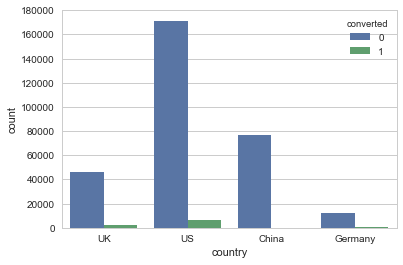

In [68]:
#Plot observation count by country and converted
sns.countplot(conversions_df.country, hue=conversions_df.converted)

In [69]:
#Calculate conversion rate by country
countryconversion_rate=conversions_df[conversions_df['converted']==1].country.value_counts()/conversions_df.country.value_counts()
countryconversion_rate

China      0.001332
Germany    0.062500
UK         0.052632
US         0.037801
Name: country, dtype: float64

Germany has the highest conversion rate

***********************************************************************************************

Which marketing channel gives highest conversion rate?

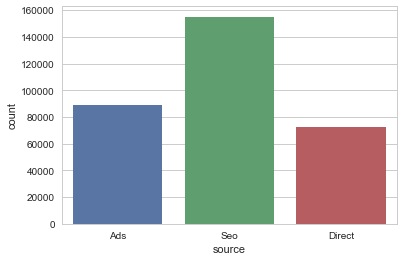

In [70]:
#Plot observation count by Marketing channel
sns.countplot(conversions_df.source)

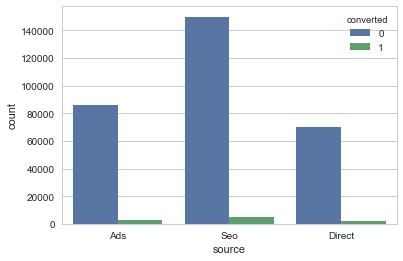

In [71]:
#Plot observation count by Marketing channel and converted
sns.countplot(conversions_df.source, hue=conversions_df.converted)

In [72]:
#Calculate marketing channel conversion rate
sourceconversion_rate=conversions_df[conversions_df['converted']==1].source.value_counts()/conversions_df.source.value_counts()
sourceconversion_rate

Seo       0.032895
Ads       0.034483
Direct    0.028169
Name: source, dtype: float64

*********************************************************************************************************

Is conversion higher among new users or established users?

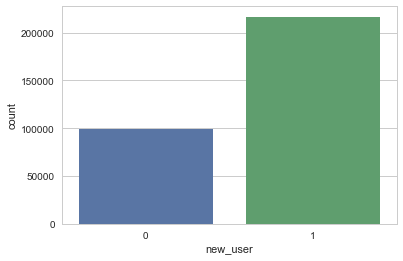

In [73]:
#Plot observation count by user type
sns.countplot(conversions_df.new_user)

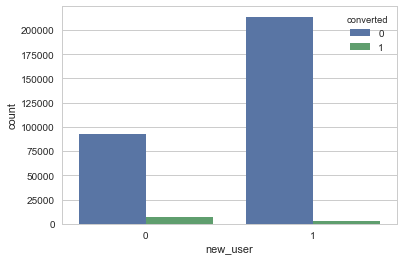

In [74]:
#Plot observation count by user type and conversion
sns.countplot(conversions_df.new_user,hue=conversions_df.converted)

In [75]:
#Calculate user type conversion rate
userconversion_rate=conversions_df[conversions_df['converted']==1].new_user.value_counts()/conversions_df.new_user.value_counts()
userconversion_rate

0    0.072002
1    0.014021
Name: new_user, dtype: float64

Conversion rate of returning users are significantly higher than the new users. We have to explore why we have a low conversion among new users.

******************************************************************************************

What is the distribution of age groups in the dataset?

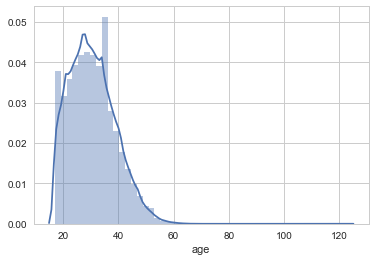

In [79]:
#Plot histogram of age
sns.distplot(conversions_df.age)

***************************************************************************************************************

How many pages does a user visit in a session?

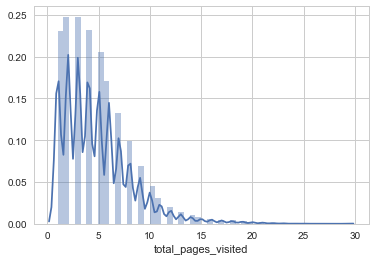

In [82]:
#Plot histogram of total_pages_visited
sns.distplot(conversions_df.total_pages_visited)

*******************************************************************

In [83]:
correlation=conversions_df.corr()

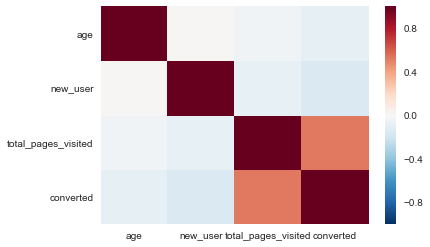

In [86]:
sns.heatmap(correlation)

****************************************************************************

#### Remove Outliers

In [90]:
conversions_df=conversions_df[conversions_df.age<=90]
conversions_df.shape

(316198, 6)

#### Data Preprocessing

In [93]:
#Get dummies for categorical variables
conversions_df=pd.get_dummies(conversions_df)
conversions_df.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


#### Train Test Split Cross Validation

In [98]:
X=conversions_df.ix[:, conversions_df.columns != 'converted']
y=conversions_df.converted
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

#### Standard Scaler

In [101]:
stdsc=StandardScaler()
X_train_std=stdsc.fit_transform(X_train)
X_test_std=stdsc.fit_transform(X_test)

#### Implement Random Forest to assess factor importances

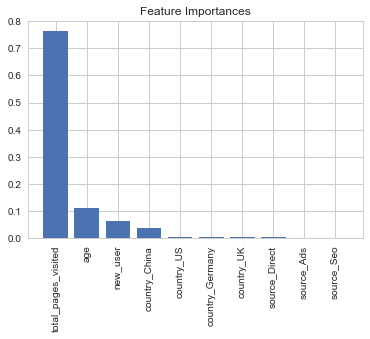

In [128]:
#Ramdom Forest
rf=RandomForestClassifier(criterion='entropy',random_state=1,n_jobs=2)
rf.fit(X_train,y_train)
features=X.columns
importances=rf.feature_importances_
indices=np.argsort(importances)[::-1]
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),importances[indices])
plt.xticks(range(X_train.shape[1]),features[indices],rotation=90)
plt.show()

#### Run predictive model

In [103]:
#Perform logistic regression
lr=LogisticRegression(C=1000.0,random_state=0)
lr.fit(X_train_std,y_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [108]:
y_pred=lr.predict(X_test)

#### Evaluate Performance Metrics

In [109]:
confmat=confusion_matrix(y_test,y_pred)
confmat

array([[87796,  4050],
       [  393,  2621]])

Confusion Matrix show high rate of True Positives

In [111]:
precisionscore=precision_score(y_test,y_pred)
precisionscore

0.3928946184979763

In [113]:
recallscore=recall_score(y_test,y_pred)
recallscore

0.86960849369608495

In [114]:
f1score=f1_score(y_test,y_pred)
f1score

0.54124935467217339

In [119]:
accuracyscore=accuracy_score(y_test,y_pred)
accuracyscore

0.9531625553447185

The model gives a high accuracy score of 95%.

*************************************************************************************************************************

#### Learnings/Recommndations from analysis